## Trabajo de Evaluación: Tarea 3 

El objetivo principal de este trabajo es el procesamiento de datos y la implementación de dos modelos para la detección automática de idiomas. 
 

In [1]:
import os
import glob
import re
import random
import string
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
import warnings
from collections import defaultdict

warnings.filterwarnings('ignore')

#### Carga de datos

Utilizaremos el corpus paralelo EuroParl, que contiene textos parlamentarios en múltiples idiomas de la Unión Europea. Seleccionaremos cinco mil oraciones de 7 idiomas diferentes: español, francés, inglés, alemán, polaco, lituano y portég.; 

In [4]:
with open("txt/es/ep-00-01-17.txt", "r", encoding="utf-8") as f:
    texto = f.read()

print(texto[:2000])

<CHAPTER ID=1>
Reanudación del período de sesiones
<SPEAKER ID=1 NAME="La Presidenta">
Declaro reanudado el período de sesiones del Parlamento Europeo, interrumpido el viernes 17 de diciembre pasado, y reitero a Sus Señorías mi deseo de que hayan tenido unas buenas vacaciones.
<P>
Como todos han podido comprobar, el gran "efecto del año 2000" no se ha producido. En cambio, los ciudadanos de varios de nuestros países han sido víctimas de catástrofes naturales verdaderamente terribles. Sus Señorías han solicitado un debate sobre el tema para los próximos días, en el curso de este período de sesiones. A la espera de que se produzca, de acuerdo con muchos colegas que me lo han pedido, pido que hagamos un minuto de silencio en memoria de todas las víctimas de las tormentas, en los distintos países de la Unión Europea afectados. Invito a todos a que nos pongamos de pie para guardar un minuto de silencio.
<P>
(El Parlamento, de pie, guarda un minuto de silencio)

<SPEAKER ID=2 NAME="Evans, Ro

Este es el formato que sigue cada archivo de cada idioma. Conocer la estructura de cada archivo es esencial para diseñar un preprocesamiento adecuado y extraer las oraciones correctamente.

In [34]:
 def limpia_texto(texto):
    texto = texto.lower()
    signos_comunes = string.punctuation
    signos_a_conservar = "¿¡çß" 
    
    signos_a_eliminar = "".join([s for s in signos_comunes if s not in signos_a_conservar])
    
    patron = f"[0-9{re.escape(signos_a_eliminar)}]"
    texto = re.sub(patron, "", texto)
    
    return texto

def procesar_archivo(ruta_archivo, min_palabras=3, max_palabras=15):
    with open(ruta_archivo, "r", encoding="utf-8") as f:
        texto = f.read()
        
        # Eliminar etiquetas tipo <SPEAKER>, <CHAPTER>, <P>, etc.
        texto = re.sub(r"<.*?>", "", texto)
        texto=limpia_texto(texto)
        
        posibles_oraciones = re.split(r'[.\n]', texto)
        
        # Filtrar por número de palabras
        oraciones = []
        for oracion in posibles_oraciones:
            oracion = oracion.strip()
            num_palabras = len(oracion.split())
            if min_palabras <= num_palabras <= max_palabras:
                oraciones.append(oracion)
                
        return oraciones


def procesar_carpeta(ruta_carpeta, limite_oraciones=5000):
    archivos_txt = glob.glob(os.path.join(ruta_carpeta, "*.txt"))
    todas_oraciones = []
    
    for archivo in archivos_txt:
        oraciones = procesar_archivo(archivo)
        todas_oraciones.extend(oraciones)
        
        if len(todas_oraciones) >= limite_oraciones:
            break
    
    # Limitar a 'limite_oraciones'
    todas_oraciones = todas_oraciones[:limite_oraciones]
    return todas_oraciones

In [7]:
idiomas_seleccionados=['es','fr','en','de','pl','lt','pt']

El objetivo es crear un dataframe con las columnas Texto e Idiomas. Para ello realizaremos una limpieza en los datos. Convertiremos todo el texto en minúsculas y eliminaremos los números y signos de puntuación que no sean descriminantes. Es decir, conservaremos aquellos signos de puntuación que identifiquen a un idioma como puede ser "¿,¡" del español o "ç" del francés. 

In [36]:
df_texto = pd.DataFrame([(x,idioma) for idioma in idiomas_seleccionados for x in procesar_carpeta(f"txt/{idioma}/")], columns=['Texto','Idioma'])
display(df_texto.head(10))

,Texto,Idioma
0,reanudación del período de sesiones,es
1,el parlamento de pie guarda un minuto de silencio,es
2,todo ello de conformidad con los principios qu...,es
3,orden de los trabajos,es
4,aplausos del grupo pse,es
5,aplausos del grupo ppede,es
6,¿algún colega tomará la palabra en nombre del ...,es
7,gracias señor poettering,es
8,escuchemos ahora al sr wurtz que hablará en co...,es
9,el parlamento rechaza la propuesta por votos ...,es


Comprobemos que efectivamente el dataset está balanceado y se mantiene una misma proporción por idiomas. 

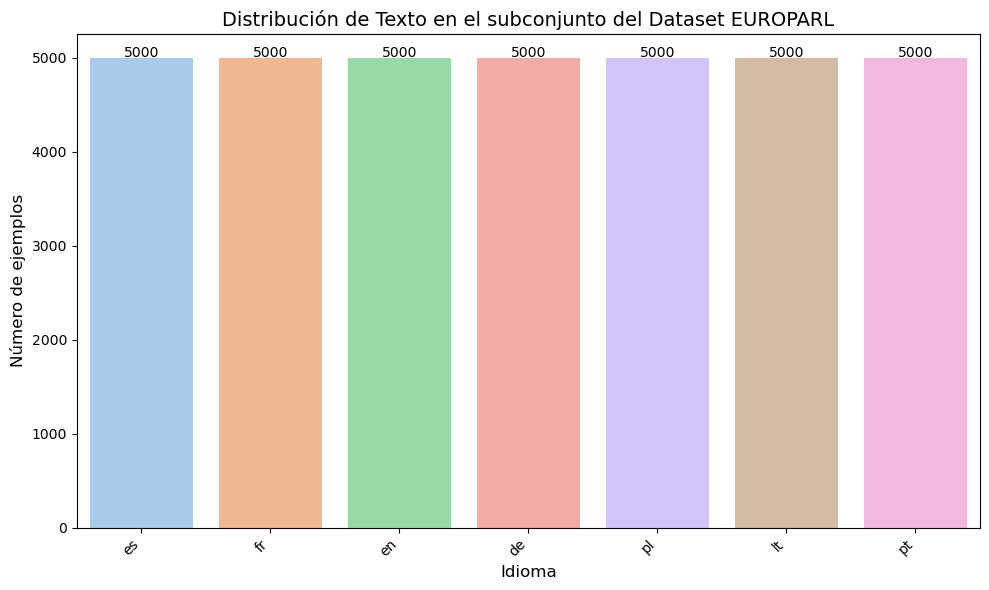

In [38]:
plt.figure(figsize=(10, 6))
text_counts = df_texto['Idioma'].value_counts()
colors = sns.color_palette("pastel", len(text_counts))
ax = sns.barplot(x=text_counts.index, y=text_counts.values, palette=colors)

plt.title('Distribución de Texto en el subconjunto del Dataset EUROPARL', fontsize=14)
plt.xlabel('Idioma', fontsize=12)
plt.ylabel('Número de ejemplos', fontsize=12)
plt.xticks(rotation=45, ha='right')
for i, count in enumerate(text_counts.values):
        ax.text(i, count + 5, str(count), ha='center', fontsize=10)
    
plt.tight_layout()
plt.show()

In [40]:
df_texto["Longitud"] = df_texto["Texto"].apply(lambda x: len(x.split()))

resumen = df_texto.groupby("Idioma").agg(
    maximo_longitud = ("Longitud", "max"),
    minimo_longitud = ("Longitud", "min"),
    media_longitud = ("Longitud", "mean"),
    mediana_longitud = ("Longitud", "median")
).reset_index()

print(resumen)

  Idioma  maximo_longitud  minimo_longitud  media_longitud  mediana_longitud
0     de               15                3          7.3112               7.0
1     en               15                3          7.0936               6.0
2     es               15                3          7.2200               6.0
3     fr               15                3          7.0366               6.0
4     lt               15                3          7.2876               6.0
5     pl               15                3          7.3370               7.0
6     pt               15                3          7.2902               6.0


Los resultados obtenidos indican que el procesamiento ha sido exitoso: se ha generado un dataset balanceado en cuanto a idiomas y controlado en cuanto a longitud de las oraciones. La longitud mínima es de 3 palabras y la máxima de 15, con una mediana centrada entre 6 y 7 palabras, exactamente como se requería. Esto garantiza homogeneidad estructural en el corpus, lo cual es fundamental para futuras tareas de modelado y análisis.

Para ahorrar recursos computacionales y evitar reprocesar los archivos originales, procederemos a guardar el dataset limpio en disco. Trabajaremos directamente con este archivo en los pasos siguientes.

In [45]:
df_texto.to_csv("dataset_oraciones_limpio.csv", index=False, encoding="utf-8")